<a href="https://colab.research.google.com/github/vindeshwariprasad/Thesis/blob/master/IMAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import shutil
from zipfile import ZipFile
import requests

# Define the GitHub repository and folder
repo_url = "https://github.com/vindeshwariprasad/Thesis"
folder_name = "dataset"

# Download the repository as a zip file
zip_url = f"{repo_url}/archive/main.zip"
zip_file_path = "/content/main.zip"
response = requests.get(zip_url, stream=True)

# Save the zip file
with open(zip_file_path, 'wb') as file:
    shutil.copyfileobj(response.raw, file)

# Extract the contents of the dataset folder
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Define the dataset path
dataset_folder = f"/content/Thesis-main/{folder_name}"

# Verify if the folder exists
if os.path.exists(dataset_folder):
    print(f"{folder_name} folder exists.")
else:
    print(f"{folder_name} folder not found.")

# Define paths for training and validation folders
training_folder = os.path.join(dataset_folder, "training")
validation_folder = os.path.join(dataset_folder, "validation")

# Verify if the folders exist
if os.path.exists(training_folder) and os.path.exists(validation_folder):
    print("Training and validation folders exist.")
else:
    print("Training or validation folders not found.")

# Define paths for sensitive and nonsensitive folders within training and validation
train_sensitive_dir = os.path.join(training_folder, "sensitive")
train_nonsensitive_dir = os.path.join(training_folder, "nonsensitive")
validation_sensitive_dir = os.path.join(validation_folder, "sensitive")
validation_nonsensitive_dir = os.path.join(validation_folder, "nonsensitive")

# Verify if the folders exist
if os.path.exists(train_sensitive_dir) and os.path.exists(train_nonsensitive_dir):
    print(f"Training sensitive folder exists: {len(os.listdir(train_sensitive_dir))} images")
    print(f"Training nonsensitive folder exists: {len(os.listdir(train_nonsensitive_dir))} images")
else:
    print("Training folders not found.")

if os.path.exists(validation_sensitive_dir) and os.path.exists(validation_nonsensitive_dir):
    print(f"Validation sensitive folder exists: {len(os.listdir(validation_sensitive_dir))} images")
    print(f"Validation nonsensitive folder exists: {len(os.listdir(validation_nonsensitive_dir))} images")
else:
    print("Validation folders not found.")






dataset folder exists.
Training and validation folders exist.
Training sensitive folder exists: 300 images
Training nonsensitive folder exists: 300 images
Validation sensitive folder exists: 50 images
Validation nonsensitive folder exists: 50 images


In [16]:
import tensorflow as tf
import numpy as np
import os

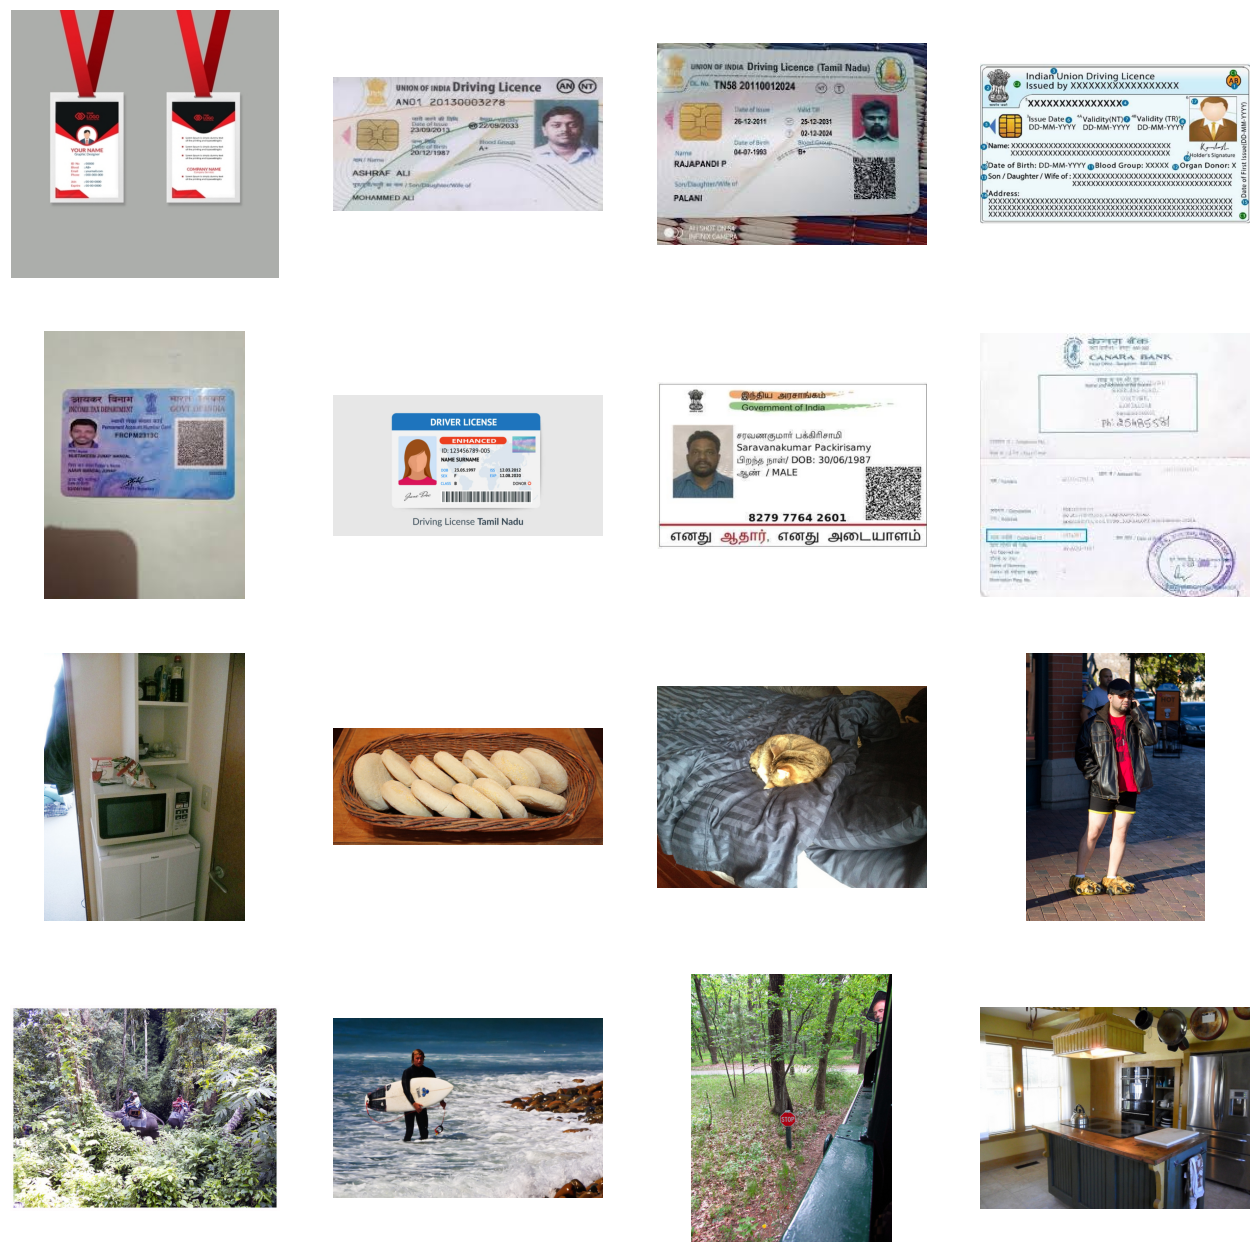

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_sensitive_dir = os.path.join(training_folder+"/sensitive")
train_nonsensitive_dir = os.path.join(training_folder+"/nonsensitive")
train_sensitive_names = os.listdir(train_sensitive_dir)
train_nonsensitive_names = os.listdir(train_nonsensitive_dir)

pic_index += 8
next_sensitive_pix = [os.path.join(train_sensitive_dir, fname)
                for fname in train_sensitive_names[pic_index-8:pic_index]]
next_nonsensitive_pix = [os.path.join(train_nonsensitive_dir, fname)
                for fname in train_nonsensitive_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_sensitive_pix+next_nonsensitive_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [18]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.98

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 98% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.models.Sequential([
  # 2D Convolution Layer - Filter, Kernel_size, activation fn
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
  # Max pooling operation for 2D data - Pool size
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # Flattens the input. Does not affect the batch size.
  tf.keras.layers.Flatten(),
  # Regular densely-connected Neural Network layer with ReLU activation function.
  tf.keras.layers.Dense(512, activation='relu'),
  # Regular densely-connected Neural Network layer with sigmoid activation function.
  tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling - 1/255 is to transform every pixel value from range [0,255] -> [0,1]
# Performing image augmentation for training data
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# flow_from_directory - Takes the path to a directory & generates batches of data.
train_generator = train_datagen.flow_from_directory(
        training_folder,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary',
        shuffle=True
       )

validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary',
        shuffle=True
        )

num_epochs = 500
# model.fit - Train the model for a fixed number of epochs
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=num_epochs,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks=[callbacks])

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/500
10/10 [==============================] - 21s 2s/step - loss: 0.6964 - accuracy: 0.5833 - val_loss: 0.5596 - val_accuracy: 0.7750
Epoch 2/500
10/10 [==============================] - 17s 2s/step - loss: 0.6313 - accuracy: 0.6867 - val_loss: 0.4251 - val_accuracy: 0.9250
Epoch 3/500
10/10 [==============================] - 21s 2s/step - loss: 0.5857 - accuracy: 0.7533 - val_loss: 0.4913 - val_accuracy: 0.8250
Epoch 4/500
10/10 [==============================] - 18s 2s/step - loss: 0.4915 - accuracy: 0.7633 - val_loss: 0.3625 - val_accuracy: 0.8250
Epoch 5/500
10/10 [==============================] - 17s 2s/step - loss: 0.5185 - accuracy: 0.7500 - val_loss: 0.3453 - val_accuracy: 0.8750
Epoch 6/500
10/10 [==============================] - 18s 2s/step - loss: 0.4955 - accuracy: 0.7733 - val_loss: 0.3609 - val_accuracy: 0.8500
Epoch 7/500
10/10 [==============================] - 17s 2s/step - loss:

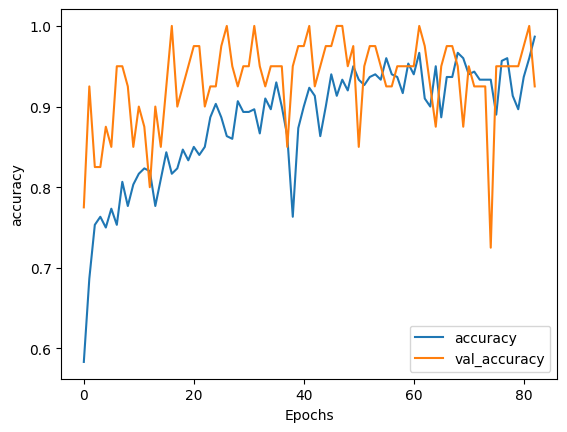

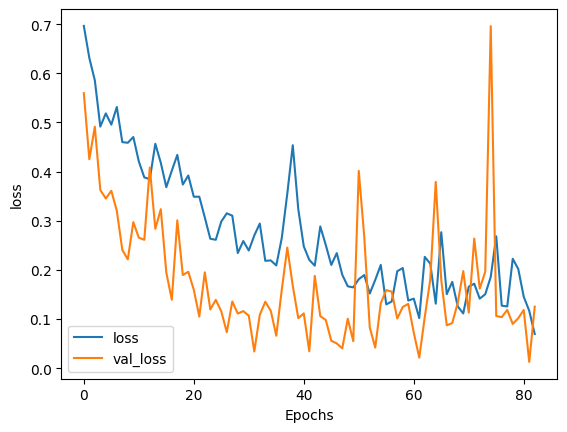

In [20]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

20/20 [==============================] - 3s 134ms/step
Confusion Matrix
Accuracy for 25 Test Data =  20.0
Accuracy for 50 Test Data =  38.775510204081634
Accuracy for 75 Test Data =  38.666666666666664
Accuracy for 100 Test Data =  44.44444444444444


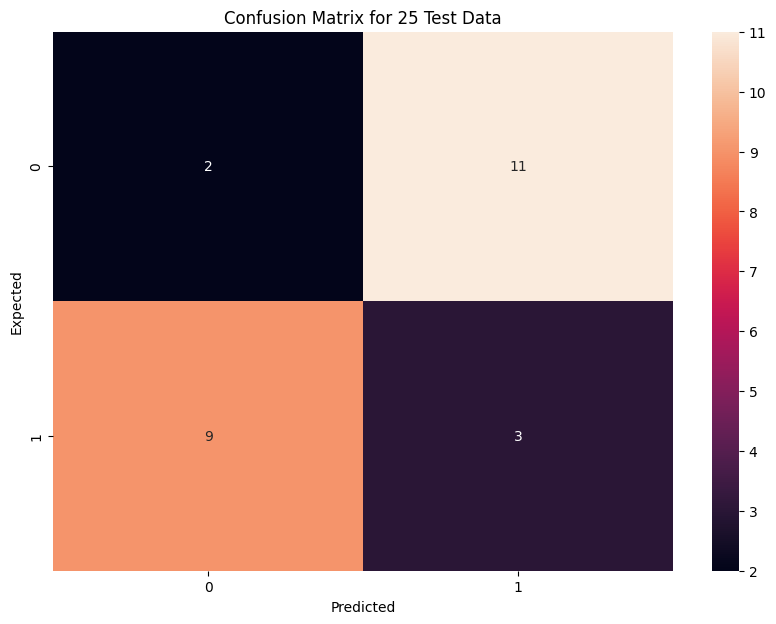

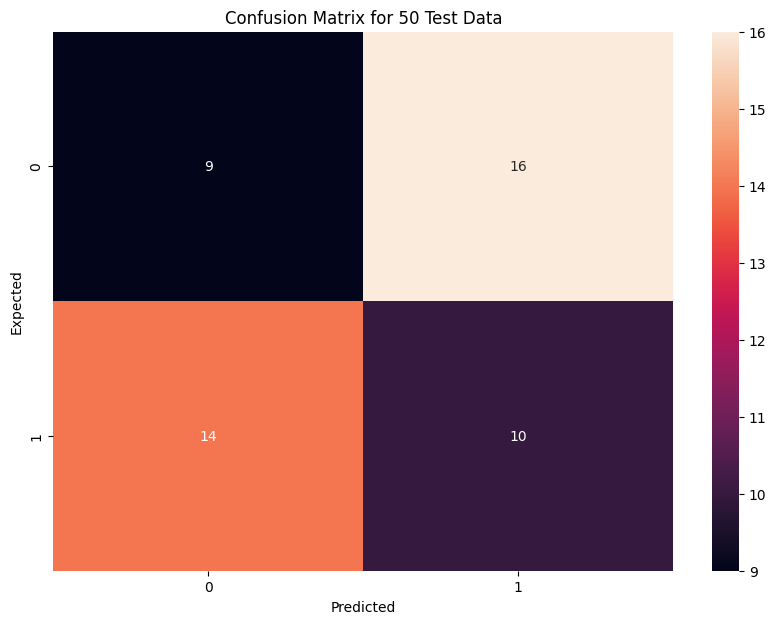

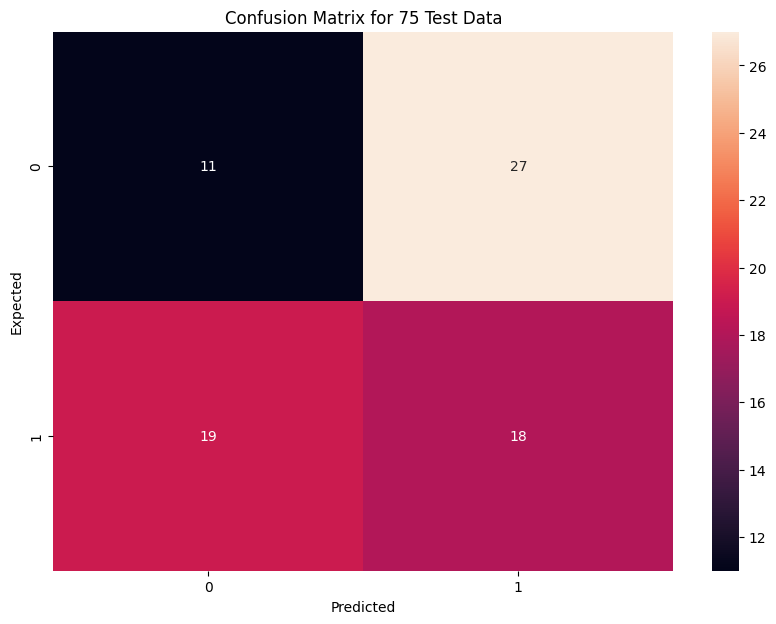

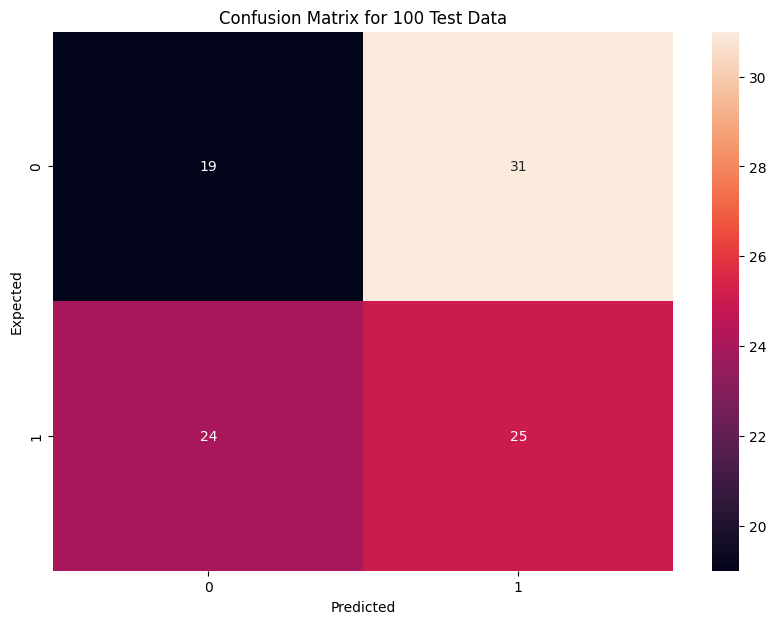

In [21]:
import seaborn
y_pred = model.predict(validation_generator, 20)
print('Confusion Matrix')
y_predicted_labels = y_pred > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  mid = 49
  start = mid-((total+1)//2)+1
  end = mid+((total+1)//2)
  cm = tf.math.confusion_matrix(labels=validation_generator.labels[start:end],predictions=y_predicted_labels[start:end])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

In [22]:
# Save and convert the model (Used for deploying in web application)
model.save('model/image_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/image_model.h5 /content/image_model
print("Model converted to JSON successfully")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved the model successfully
Selecting previously unselected package python3-distlib.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../00-python3-distlib_0.3.4-1_all.deb ...
Unpacking python3-distlib (0.3.4-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../01-python3-filelock_3.6.0-1_all.deb ...
Unpacking python3-filelock (3.6.0-1) ...
Selecting previously unselected package python3-setuptools.
Preparing to unpack .../02-python3-setuptools_59.6.0-1.2ubuntu0.22.04.1_all.deb ...
Unpacking python3-setuptools (59.6.0-1.2ubuntu0.22.04.1) ...
Selecting previously unselected package python3-wheel.
Preparing to unpack .../03-python3-wheel_0.37.1-2ubuntu0.22.04.1_all.deb ...
Unpacking python3-wheel (0.37.1-2ubuntu0.22.04.1) ...
Selecting previously unselected package python3-pip.
Preparing to unpack .../04-python3-pip_22.0.2+dfsg-1ubuntu0.4_all.deb ...
Unpacking python3-pip (22.0.2+dfsg-1ubuntu0.4) ...
Select

Saving Screenshot 2024-03-03 195036.png to Screenshot 2024-03-03 195036.png
1/1 [==============================] - 0s 34ms/step
[1.]
Screenshot 2024-03-03 195036.png - Sensitive


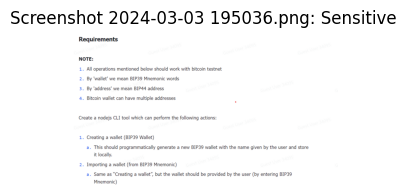

In [25]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
result = dict()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " - Sensitive")
    result[fn] = "Sensitive"
  else:
    print(fn + " - Non-sensitive")
    result[fn] = "Non-sensitive"

plt.figure(figsize=(20,20))

for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)